# Decision Tree Regresion for Trading


    * Retrieve market data for a financial instrument.
    * Introduce the Predictor variables (i.e. Technical indicators, Sentiment indicators, Breath indicators, etc.)
    * Setup the Target variable or the desired output.
    * Split data between training and test data.
    * Generate the decision tree training the model.
    * Make forecast.
    * Testing and analyzing the model.


In [362]:
import os
import pandas as pd
import datetime as dt
import numpy as np
from markupsafe import Markup
import fix_yahoo_finance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree, metrics, neighbors
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, explained_variance_score
from sklearn.externals import joblib

import xgboost as xgb

from util import create_df_benchmark, fetchOnlineData, get_data, \
    symbol_to_path
from indicators import get_indicators

%matplotlib inline
import matplotlib.pyplot as plt

## Retrieve market data for a financial instrument.

In [363]:
symbol = "AABA"


# Set Forecast date
forecast_date = dt.date.today()


# Get Forecast time
forecast_time = 7

# Get Lookback
forecast_lookback = 365


# Set lookback date of data to train and test
start_d = forecast_date - dt.timedelta(forecast_lookback)
start_d = f"{start_d:%Y-%m-%d}"
yesterday = dt.date.today() - dt.timedelta(1)

In [364]:
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


## Normalize data

In [365]:
# Normalize the prices Dataframe
normed = portf_value.copy()
#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)

# Introduce the Predictor variables

In [366]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

date
2018-02-27    0.070745
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
2018-03-20    0.051882
2018-03-21    0.027507
2018-03-22   -0.015318
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
2018-04-04   -0.120779
2018-04-05   -0.111310
2018-04-06   -0.094140
2018-04-09   -0.062466
2018-04-10   -0.066350
                ...   
2018-12-27   -0.077205
2018-12-28   -0.070268
2018-12-31   -0.065635
2019-01-02   -0.043109
2019-01-03   -0.060724
2019-01-04    0.017678
2019-01-07    0.051666
2019-01-08    0.096855
2019-01-09    0.129779
2019-01-10    0.089983
2019-01-11    0.084699
2019-01-14    0.067524
2019-0

,AABA,Momentum,SMA,RSI
date,,,,
2018-02-12,71.099998,0.000000,0.000000,89.454981
2018-02-13,71.309998,0.000000,0.000000,89.454981
2018-02-14,73.660004,0.000000,0.000000,89.454981
2018-02-15,74.400002,0.000000,0.000000,89.454981
2018-02-16,73.510002,0.000000,0.000000,89.454981
2018-02-20,74.589996,0.000000,0.000000,89.454981
2018-02-21,75.110001,0.000000,0.000000,89.454981
2018-02-22,75.519997,0.000000,0.000000,90.020556
2018-02-23,77.760002,0.000000,0.000000,92.563023


In [460]:
last_price =  normed.loc[normed.index[-1]][0]
last_price

68.519997

In [465]:
last_date = normed.loc[normed.index[-1]].name
last_date = last_date.strftime("%Y-%m-%d")

# Setup the Target variable or the desired output.

In [367]:
# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

# Split data between training and test data.

In [368]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [369]:
X_train.size, y_train.size

(350, 175)

In [370]:
X_test.size, y_test.size

(150, 75)

# Generate the decision tree training the model.

In [371]:
def model_fit_pred(model, X_train, y_train, X_test):
    '''Getting metrics'''

    # Measuring predictions

    # Accuracy
    scores = cross_val_score(model, X_test, y_test, cv=7)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() / 2))

    # Coefficient of determination R^2
    '''
    The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
    '''
    coef_deter = model.score(X_train, y_train)
    print('Coefficient of determination R^2: %s' % coef_deter)

    # Forecast error
    '''
    The units of the forecast error are the same as the units of the prediction. A forecast error of zero indicates no error, or perfect skill for that forecast.
    '''
    forecast_errors = [y_test[i] - y_pred[i] for i in range(len(y_test))]
    #print('Forecast Errors: %s' % forecast_errors)

    # Forecast bias
    '''
    Mean forecast error, also known as the forecast bias. A forecast bias of zero, or a very small number near zero, shows an unbiased model.
    '''
    bias = sum(forecast_errors) * 1.0 / len(y_test)
    print('Bias: %f' % bias)

    # Mean absolute error
    '''
    A mean absolute error of zero indicates no error.
    '''
    mae = metrics.mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

    # Mean squared error
    '''
    A mean squared error of zero indicates perfect skill, or no error.
    '''
    mse = metrics.mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

    # Root mean squared error
    '''
    As with the mean squared error, an RMSE of zero indicates no error.
    '''
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    results = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})
    results.sort_index(inplace=True)
    
    return results, coef_deter, forecast_errors, bias, mae, mse, rmse

In [372]:
model = tree.DecisionTreeRegressor(max_depth=10)

In [373]:
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [374]:
# Predictions
y_pred = model.predict(X_test)

## Visualize the model

In [ ]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr,
                  out_file=None,
                  filled=True,
                  feature_names=feature_cols)
graphviz.Source(dot_data)

# Testing and analizing the model

In [375]:
# Results
results = model_fit_pred(model, X_train, y_train, X_test)


Accuracy: -3.11 (+/- 1.51)
Coefficient of determination R^2: 0.9729640425214516
Bias: -11.106778
Mean Absolute Error: 11.106777617777778
Mean Squared Error: 137.97235968231
Root Mean Squared Error: 11.746163615509108


In [285]:
prediction = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})

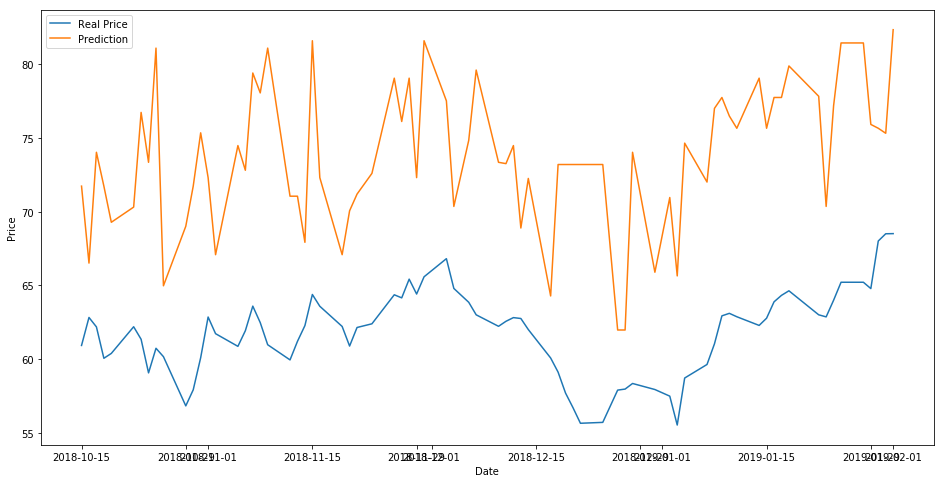

In [286]:
plt.figure(figsize=(16,8))
plt.plot(prediction)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

###  Cross-validation for performing GridSerach
Using cross-validation for performing GridSerach on the parameter 'min_samples_split', then using the best estimator for scoring on the valiation/holdout set.

In [287]:

scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))
y_pred = g_cv.best_estimator_.predict(X_test)

In [288]:
predictions = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})

# Order dataframe
predictions.sort_index(inplace=True)

In [289]:
# Results
model_fit_pred(model, X_train, y_train, X_test)

Accuracy: -2.18 (+/- 1.12)
Coefficient of determination R^2: 0.9594802679961099
Bias: -11.436903
Mean Absolute Error: 11.436903478952381
Mean Squared Error: 141.221448405278
Root Mean Squared Error: 11.883663088680947


(                Price  Price prediction
 date                                   
 2018-10-15  60.930000         71.982857
 2018-10-16  62.830002         70.221667
 2018-10-17  62.189999         70.221667
 2018-10-18  60.060001         71.982857
 2018-10-19  60.389999         65.537502
 2018-10-22  62.200001         70.060001
 2018-10-23  61.349998         76.746666
 2018-10-24  59.070000         76.752501
 2018-10-25  60.740002         74.927502
 2018-10-26  60.169998         65.537502
 2018-10-29  56.830002         69.018332
 2018-10-30  57.919998         71.982857
 2018-10-31  60.099998         72.290001
 2018-11-01  62.860001         72.632498
 2018-11-02  61.730000         69.245713
 2018-11-05  60.869999         72.142857
 2018-11-06  61.930000         72.200000
 2018-11-07  63.599998         76.863332
 2018-11-08  62.480000         76.030002
 2018-11-09  60.980000         74.927502
 2018-11-12  59.950001         70.002857
 2018-11-13  61.209999         70.002857
 2018-11-14  62.

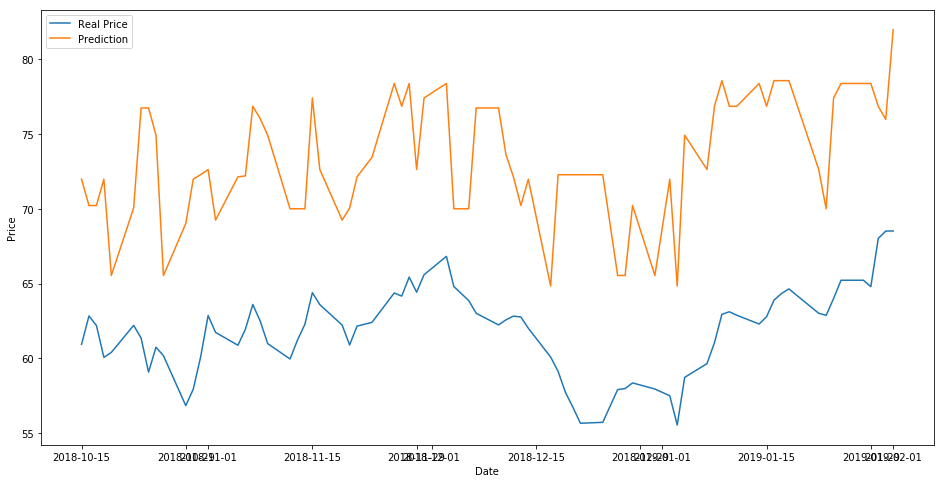

In [290]:
plt.figure(figsize=(16,8))
plt.plot(predictions)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

### Gradient Boosting regression

In [291]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 134.2068


Text(0, 0.5, 'Deviance')

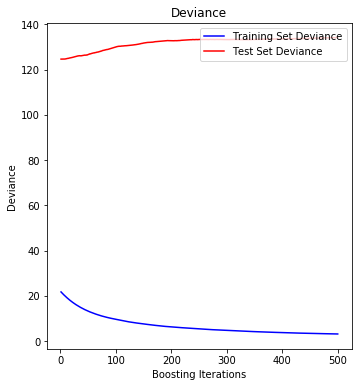

In [292]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [293]:
y_pred = clf.predict(X_test)

In [294]:
predictions = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})

# Order dataframe
predictions.sort_index(inplace=True)

In [295]:
# Results
model_fit_pred(model, X_train, y_train, X_test)

Accuracy: -2.41 (+/- 1.12)
Coefficient of determination R^2: 0.9594802679961099
Bias: -11.340076
Mean Absolute Error: 11.34007574974654
Mean Squared Error: 134.2068155449056
Root Mean Squared Error: 11.584766529581232


(                Price  Price prediction
 date                                   
 2018-10-15  60.930000         69.204408
 2018-10-16  62.830002         70.377335
 2018-10-17  62.189999         71.874753
 2018-10-18  60.060001         70.724813
 2018-10-19  60.389999         70.246041
 2018-10-22  62.200001         73.401822
 2018-10-23  61.349998         75.271797
 2018-10-24  59.070000         71.965266
 2018-10-25  60.740002         72.226470
 2018-10-26  60.169998         70.776762
 2018-10-29  56.830002         69.255816
 2018-10-30  57.919998         70.724813
 2018-10-31  60.099998         71.164678
 2018-11-01  62.860001         71.897914
 2018-11-02  61.730000         71.992675
 2018-11-05  60.869999         71.702574
 2018-11-06  61.930000         70.616154
 2018-11-07  63.599998         77.213962
 2018-11-08  62.480000         70.181751
 2018-11-09  60.980000         71.388572
 2018-11-12  59.950001         70.097719
 2018-11-13  61.209999         69.532895
 2018-11-14  62.

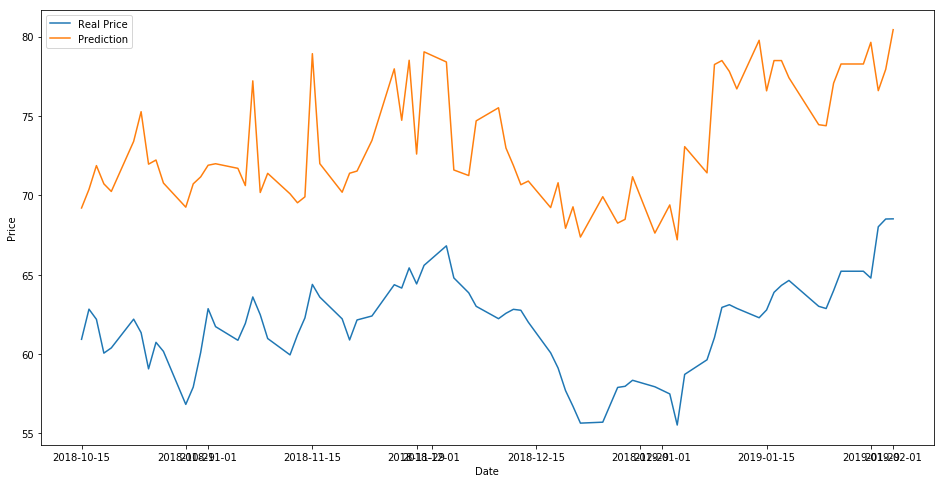

In [296]:
plt.figure(figsize=(16,8))
plt.plot(predictions)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

### XBoost

In [341]:
import pickle
import xgboost as xgb

In [332]:
# grid search
print('Select Model...')
start_time  = dt.datetime.now()



parameters = {'n_estimators': [100, 120],
              'max_depth':[2, 3, 4, 5, 6], 
              'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
model = GridSearchCV(estimator=xgb, param_grid=parameters, cv=10, n_jobs=-1)
print("parameters:")

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, param_grid=parameters,verbose=1)
clf.fit(X,y)
print('Best score :', clf.best_score_)
print('Best parameters :', clf.best_params_)    

Select Model...
parameters:
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best score : -6.445945481270077
Best parameters : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 120}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    5.1s finished


In [337]:
params = {'n_estimators': 120,
              'max_depth': 2, 
              'learning_rate' : 0.1}
clf = GradientBoostingRegressor(**params) 
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [338]:
# make predictions for test data
y_pred = clf.predict(X_test)
print(explained_variance_score(y_pred,y_test))
#predictions = [round(value) for value in y_pred]

predictions = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})

# Order dataframe
predictions.sort_index(inplace=True)

0.584793527027828


In [339]:
# Results
model_fit_pred(clf, X_train, y_train, X_test)

Accuracy: -1.89 (+/- 1.18)
Coefficient of determination R^2: 0.7878328366294123
Bias: -11.188463
Mean Absolute Error: 11.188462714837172
Mean Squared Error: 129.80937018860786
Root Mean Squared Error: 11.393391513882417


(                Price  Price prediction
 date                                   
 2018-10-15  60.930000         68.975775
 2018-10-16  62.830002         69.975274
 2018-10-17  62.189999         71.194194
 2018-10-18  60.060001         70.980254
 2018-10-19  60.389999         69.761333
 2018-10-22  62.200001         73.446346
 2018-10-23  61.349998         74.257606
 2018-10-24  59.070000         72.137225
 2018-10-25  60.740002         72.016540
 2018-10-26  60.169998         70.868872
 2018-10-29  56.830002         69.052546
 2018-10-30  57.919998         70.980254
 2018-10-31  60.099998         70.704120
 2018-11-01  62.860001         71.283312
 2018-11-02  61.730000         70.990456
 2018-11-05  60.869999         71.711070
 2018-11-06  61.930000         70.559703
 2018-11-07  63.599998         77.006372
 2018-11-08  62.480000         70.455313
 2018-11-09  60.980000         72.016540
 2018-11-12  59.950001         71.429216
 2018-11-13  61.209999         71.097658
 2018-11-14  62.

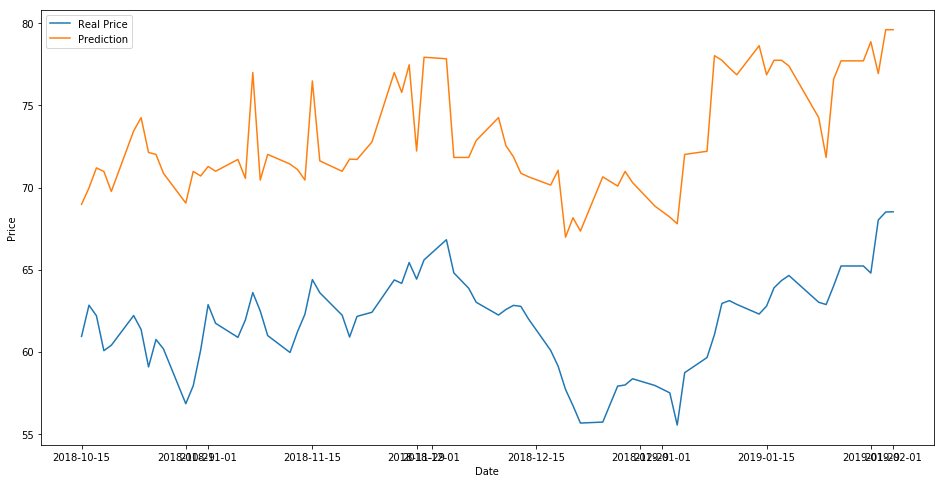

In [336]:
plt.figure(figsize=(16,8))
plt.plot(predictions)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

### Save model

In [342]:
# save model to file
#joblib.dump(model, "./xgboost.dat")
# The sklearn API models are picklable
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(clf, open("./xgboost.pkl", "wb"))

Pickling sklearn API models


In [343]:
# load model
clf = pickle.load(open("./xgboost.pkl", "rb"))

In [344]:
clf.predict(X_test)

array([68.97577502, 69.97527353, 71.19419435, 70.98025369, 69.76133286,
       73.44634616, 74.25760649, 72.13722508, 72.01653975, 70.86887202,
       69.0525459 , 70.98025369, 70.7041199 , 71.28331165, 70.990456  ,
       71.71107   , 70.55970256, 77.0063716 , 70.45531324, 72.01653975,
       71.42921634, 71.09765835, 70.45531324, 76.49447181, 71.62345857,
       70.990456  , 71.73190299, 71.71107   , 72.77379255, 77.0063716 ,
       75.79453754, 77.47518824, 72.22349727, 77.93734527, 77.84428388,
       71.83257069, 71.83257069, 72.86301193, 74.2612393 , 72.54144146,
       71.87889013, 70.87194002, 70.65799936, 70.14871398, 71.12815011,
       67.38500619, 68.22938781, 67.62573202, 70.65173337, 70.08831876,
       70.98025369, 70.30225943, 68.86809718, 68.19995554, 67.78988175,
       72.01653975, 72.20865494, 78.03342393, 77.75260567, 77.28952988,
       76.86853504, 78.64007713, 76.86853504, 77.75260567, 77.75260567,
       77.40609294, 74.26156176, 71.83257069, 76.59194295, 77.71

In [346]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


## Predicting future days values

In [360]:
# load model
model = pickle.load(open("./xgboost.pkl", "rb"))

# Normalize the prices Dataframe
normed = portf_value.copy()
# normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
#normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)

# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

# Bussines days
start = forecast_date.strftime("%Y-%m-%d")
rng = pd.date_range(pd.Timestamp(start), periods=forecast_time, freq='B')
bussines_days = rng.strftime('%Y-%m-%d %H:%M:%S')


# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)
dataset = pd.DataFrame()

# Create momentum column
dataset['Momentum'] = sym_mom.values;

# Create RSI column
dataset['RSI'] = rsi_value;

# Clean nan values
dataset = dataset.fillna(0)

for i in bussines_days:
    
    # Get indicators
    sym_mom, sma, q, rsi_value = get_indicators(dataset, symbol)


    # Calculate price
    prediction = model.predict(dataset)
    
    # Add last value of result to normed
    p = prediction[-1]
    print('Prediction: ', p)
    normed.loc[len(normed)] = [p, i]
    
    # Add last indicators to dataset
    normed.loc[len(normed)] = [sym_mom.values, rsi_value]


normed.set_index('date', inplace=True);

Date
2018-02-20    0.028686
2018-02-21    0.021488
2018-02-22    0.046563
2018-02-23    0.124512
2018-02-26    0.107832
2018-02-27    0.070745
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
2018-03-20    0.051882
2018-03-21    0.027507
2018-03-22   -0.015318
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
                ...   
2018-12-19   -0.109568
2018-12-20   -0.111964
2018-12-21   -0.116807
2018-12-24   -0.104773
2018-12-26   -0.074636
2018-12-27   -0.077205
2018-12-28   -0.070268
2018-12-31   -0.065635
2019-01-02   -0.043109
2019-01-03   -0.060724
2019-01-04    0.017678
2019-01-07    0.051666
2019-0

KeyError: 'AABA'